In [1]:
import numpy as np
from collections import Counter
from qiskit import IBMQ,Aer,schedule, execute, QuantumCircuit, QuantumRegister, ClassicalRegister, transpile
from qiskit.tools.visualization import plot_histogram
from qiskit.visualization import timeline_drawer
from qiskit.visualization.pulse_v2 import draw, IQXDebugging
from qiskit.tools.monitor import job_monitor
from qiskit.providers.aer.noise import NoiseModel
from qiskit.providers.aer import AerSimulator
import qiskit.quantum_info as qi
from qiskit.providers.aer.noise import QuantumError, ReadoutError

# Tomography functions
from qiskit_experiments.framework import ParallelExperiment
from qiskit_experiments.library import StateTomography


# Seeds
from numpy.random import Generator, PCG64
rng = Generator(PCG64(1897))
MY_SEEDS = rng.integers(0,high=10**8,size=100)


import KSEM
from importlib import reload  
KSEM = reload(KSEM)
from KSEM import KSQS, EMLearn

import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

# plt.rcParams['text.usetex'] = True
fig_size = (8,6)
fig_dpi = 150

In [2]:
IBMQ.load_account()

<AccountProvider for IBMQ(hub='ibm-q', group='open', project='main')>

In [4]:
provider = IBMQ.get_provider(hub="ibm-q-pnnl", group="internal", project="default")
name = "ibm_hanoi"
backend = provider.get_backend(name)
backend_noise_model = NoiseModel.from_backend(backend)
# # Remove readout errros
# p0given1 = 0
# p1given0 = 1
# rde = ReadoutError([[1 - p1given0, p1given0], [p0given1, 1 - p0given1]])
# for i in range(backend.configuration().num_qubits):
#     backend_noise_model._local_readout_errors[(i,)] = rde
den_simu = AerSimulator(method='density_matrix',noise_model=backend_noise_model)

n_qubits = 3
reps = 8
max_num_itrs = 10

/home/firepanda415/anaconda3/envs/quantum/lib/python3.9/site-packages/qiskit_aer/noise/device/models.py:365: UserWarning: Device model returned an invalid T_2 relaxation time greater than the theoretical maximum value 2 * T_1 (248486.40446034473 > 2 * 104611.66931085872). Truncating to maximum value.
  warn("Device model returned an invalid T_2 relaxation time greater than"
/home/firepanda415/anaconda3/envs/quantum/lib/python3.9/site-packages/qiskit_aer/noise/device/models.py:365: UserWarning: Device model returned an invalid T_2 relaxation time greater than the theoretical maximum value 2 * T_1 (232360.31808010972 > 2 * 97355.2679531514). Truncating to maximum value.
  warn("Device model returned an invalid T_2 relaxation time greater than"
/home/firepanda415/anaconda3/envs/quantum/lib/python3.9/site-packages/qiskit_aer/noise/device/models.py:365: UserWarning: Device model returned an invalid T_2 relaxation time greater than the theoretical maximum value 2 * T_1 (207782.54392148953 > 

/home/firepanda415/anaconda3/envs/quantum/lib/python3.9/site-packages/qiskit_aer/noise/device/models.py:365: UserWarning: Device model returned an invalid T_2 relaxation time greater than the theoretical maximum value 2 * T_1 (248486.40446034473 > 2 * 104611.66931085872). Truncating to maximum value.
  warn("Device model returned an invalid T_2 relaxation time greater than"
/home/firepanda415/anaconda3/envs/quantum/lib/python3.9/site-packages/qiskit_aer/noise/device/models.py:365: UserWarning: Device model returned an invalid T_2 relaxation time greater than the theoretical maximum value 2 * T_1 (248486.40446034473 > 2 * 104611.66931085872). Truncating to maximum value.
  warn("Device model returned an invalid T_2 relaxation time greater than"
/home/firepanda415/anaconda3/envs/quantum/lib/python3.9/site-packages/qiskit_aer/noise/device/models.py:365: UserWarning: Device model returned an invalid T_2 relaxation time greater than the theoretical maximum value 2 * T_1 (232360.31808010972 

In [5]:
backend_noise_model.to_dict()['errors'][-1]

{'type': 'roerror',
 'operations': ['measure'],
 'probabilities': [[0.9922, 0.0078], [0.010199999999999987, 0.9898]],
 'gate_qubits': [(26,)]}

In [6]:
print(backend.properties().to_dict()[ 'last_update_date'])

2022-11-17 09:35:09-05:00


In [7]:
from qiskit.visualization import plot_error_map, plot_gate_map
%matplotlib inline

# plot_error_map(backend, figsize=(18, 12))

In [8]:
from qiskit import Aer
def single_iter(n_qubits=2):
    iterate = QuantumCircuit(n_qubits)
    iterate.h(0)
    iterate.cx(0,1)
    iterate.cx(1,2)
    iterate.barrier()
    iterate.cx(1,2)
    iterate.cx(0,1)
    iterate.h(0)
    iterate.barrier()
    return iterate

def iterative_circ(num_itrs, n_qubits=2, save_den = True):   
    total_circ = QuantumCircuit(n_qubits)
    for i in range(num_itrs):
        total_circ.compose(single_iter(n_qubits), inplace=True)
    if save_den:
        total_circ.save_density_matrix(pershot=False)
    total_circ.measure_all()
    return total_circ

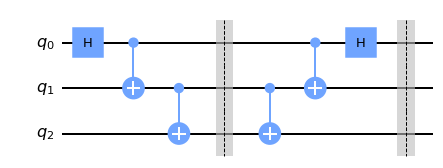

In [9]:
single_iter(n_qubits).draw("mpl")

10


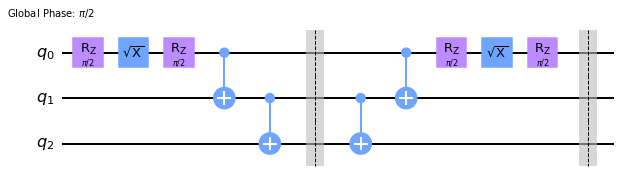

In [10]:
temp_circ = transpile(single_iter(n_qubits), backend=den_simu)
print(temp_circ.depth())
temp_circ.draw("mpl")

In [11]:
temp_circ2 = iterative_circ(max_num_itrs, n_qubits, save_den = False)
temp_circ3 = transpile(temp_circ2, backend=backend)
print("Depth:", temp_circ3.depth())
print("T1:", backend.properties().qubit_property(0)['T1'][0], "sec")
print("T2:", backend.properties().qubit_property(0)['T2'][0], "sec")
dt = backend.configuration().dt # sec
temp_sch = schedule(temp_circ3, backend)
print("Circuit Operation Time:",(temp_sch.stop_time - temp_sch.start_time)*dt, "sec")

Depth: 101
T1: 0.0001893559093040918 sec
T2: 0.000305469454459999 sec
Circuit Operation Time: 1.3262222222222221e-05 sec


## Qiskit Backend-noise Simulation

Obtain measurement data and actual quantum states (from a backend-noise simulator)

Note that the outputs does not have measurement noise because the probabilities are obtained from density matrix object, instead of measurement operator API.

In [12]:
unitary_simulator = Aer.get_backend('aer_simulator')
unitary_circ = transpile(single_iter(n_qubits), backend=den_simu)
unitary_circ.save_unitary()
unitary_result = unitary_simulator.run(unitary_circ).result()
unitary = unitary_result.get_unitary(unitary_circ)

unitaries = []
for i in range(1, max_num_itrs+1):
    gate = unitary.data
    F = np.kron(gate.conjugate(), gate)
    unitaries.append(F)

In [13]:
trans_circ = transpile(iterative_circ(3, n_qubits), backend=den_simu)
iter_res = den_simu.run(trans_circ,shots=8192*reps,seed_simulator=np.random.randint(10**8)).result()
iter_res.get_counts()

{'110': 163,
 '100': 654,
 '111': 170,
 '011': 772,
 '101': 173,
 '001': 1326,
 '010': 1738,
 '000': 60540}

In [14]:
total_simu_dens = [] # quantum state in density-matrix form
total_simu_probs = [] # measurement result
total_simu_purs = [] # purity
for i in range(1, max_num_itrs+1):
    my_seed = MY_SEEDS[i]
    trans_circ = transpile(iterative_circ(i, n_qubits, save_den = True), seed_transpiler=my_seed, backend=den_simu,optimization_level=0)
    iter_res = den_simu.run(trans_circ,shots=8192*reps,seed_simulator=my_seed).result()
    iter_den = iter_res.data()['density_matrix']
    total_simu_dens.append(iter_den)
    
    trans_circ = transpile(iterative_circ(i, n_qubits, save_den = False), seed_transpiler=my_seed, backend=den_simu,optimization_level=0)
    iter_res = den_simu.run(trans_circ,shots=8192*reps,seed_simulator=my_seed).result()
    total_simu_probs.append(KSEM.dictToVec(iter_res.get_counts()))
    total_simu_purs.append(np.real(iter_den.purity()))
    
print("Purity")
for pu in total_simu_purs:
    print(pu)
    
print("\nProb Vec")
for p in total_simu_probs:
    print(p)

Purity
0.9651274076576467
0.9318186975723179
0.9000016505501656
0.8696074261288629
0.8405704033432203
0.8128280290350431
0.7863206733481428
0.760991492066595
0.7367862954706746
0.7136534234004542

Prob Vec
[9.55902100e-01 1.02539062e-02 1.80664062e-02 4.33349609e-03
 8.27026367e-03 1.29699707e-03 1.11389160e-03 7.62939453e-04]
[0.94024658 0.01519775 0.02107239 0.00857544 0.0088501  0.00192261
 0.00228882 0.00184631]
[0.92121887 0.02070618 0.02635193 0.01220703 0.010849   0.00320435
 0.00265503 0.00280762]
[0.90777588 0.0243988  0.02848816 0.01699829 0.01107788 0.00436401
 0.00320435 0.00369263]
[0.89155579 0.03018188 0.03286743 0.0196228  0.01210022 0.00521851
 0.00428772 0.00416565]
[0.87428284 0.0358429  0.03671265 0.02346802 0.01255798 0.00579834
 0.00578308 0.0055542 ]
[0.86010742 0.03930664 0.0403595  0.02774048 0.01325989 0.00747681
 0.00582886 0.00592041]
[0.84750366 0.04412842 0.0423584  0.03016663 0.01400757 0.00811768
 0.00671387 0.00700378]
[0.83216858 0.04800415 0.04675293 

## State Tomography

### Use a Noise Model without Measurement Error for Tomography

In [15]:
backend_noise_model_for_tomo = NoiseModel.from_backend(backend)
# Remove readout errros
p0given1 = 0
p1given0 = 0
rde = ReadoutError([[1 - p1given0, p1given0], [p0given1, 1 - p0given1]])
for i in range(backend.configuration().num_qubits):
    backend_noise_model_for_tomo._local_readout_errors[(i,)] = rde
den_simu_for_tomo = AerSimulator(method='density_matrix',noise_model=backend_noise_model_for_tomo)

/home/firepanda415/anaconda3/envs/quantum/lib/python3.9/site-packages/qiskit_aer/noise/device/models.py:365: UserWarning: Device model returned an invalid T_2 relaxation time greater than the theoretical maximum value 2 * T_1 (248486.40446034473 > 2 * 104611.66931085872). Truncating to maximum value.
  warn("Device model returned an invalid T_2 relaxation time greater than"
/home/firepanda415/anaconda3/envs/quantum/lib/python3.9/site-packages/qiskit_aer/noise/device/models.py:365: UserWarning: Device model returned an invalid T_2 relaxation time greater than the theoretical maximum value 2 * T_1 (232360.31808010972 > 2 * 97355.2679531514). Truncating to maximum value.
  warn("Device model returned an invalid T_2 relaxation time greater than"
/home/firepanda415/anaconda3/envs/quantum/lib/python3.9/site-packages/qiskit_aer/noise/device/models.py:365: UserWarning: Device model returned an invalid T_2 relaxation time greater than the theoretical maximum value 2 * T_1 (207782.54392148953 > 

Device model returned a depolarizing error parameter greater than maximum allowed value (1.067074 > 1.066667). Truncating to maximum value.
Device reported a gate error parameter greater than maximum allowed value (1.000000 > 0.800000). Truncating to maximum value.
Device model returned a depolarizing error parameter greater than maximum allowed value (1.067187 > 1.066667). Truncating to maximum value.
/home/firepanda415/anaconda3/envs/quantum/lib/python3.9/site-packages/qiskit_aer/noise/device/models.py:365: UserWarning: Device model returned an invalid T_2 relaxation time greater than the theoretical maximum value 2 * T_1 (160336.2964006462 > 2 * 79166.67863253632). Truncating to maximum value.
  warn("Device model returned an invalid T_2 relaxation time greater than"
Device reported a gate error parameter greater than maximum allowed value (1.000000 > 0.800000). Truncating to maximum value.
Device model returned a depolarizing error parameter greater than maximum allowed value (1.06

In [16]:
tomo_dens = [] # quantum state in density-matrix form
tomo_probs = [] # measurement result
tomo_purs = [] # purity
for i in range(1, max_num_itrs+1):
    my_seed = MY_SEEDS[i]
    tomo_target_circ = transpile(iterative_circ(i, n_qubits, save_den = False), seed_transpiler=my_seed, backend=den_simu_for_tomo,optimization_level=0)
    qstexp = StateTomography(tomo_target_circ)
    qstdata = qstexp.run(den_simu, seed_simulation=my_seed).block_for_results()
    tomo_state =  qstdata.analysis_results("state")
    
    tomo_dens.append(tomo_state.value.data)
    tomo_probs.append(tomo_state.value.probabilities())
    tomo_purs.append(np.real(tomo_state.value.purity()))
    
print("Tomography Purity")
for pu in tomo_purs:
    print(pu)
    
print("\nTomography Prob Vec")
for p in tomo_probs:
    print(p)

Tomography Purity
0.9007873240831933
0.875378374047329
0.8474975332942202
0.8248718021275038
0.7992548741127422
0.7652168631501075
0.7382301070330939
0.7226705015245648
0.6996770954825713
0.6904441102799028

Tomography Prob Vec
[0.94764718 0.01055154 0.01687745 0.00501874 0.00799867 0.00516882
 0.00494396 0.00179363]
[0.93317471 0.0146705  0.02205923 0.00549355 0.00982273 0.0062237
 0.00503372 0.00352186]
[0.91851541 0.01444685 0.02587122 0.01232617 0.01076068 0.00671071
 0.00539344 0.00597552]
[0.90494338 0.02283516 0.02442944 0.01655796 0.01459371 0.00718059
 0.00444678 0.00501299]
[0.89041643 0.02506182 0.03013891 0.02097569 0.01224401 0.0092413
 0.00840372 0.00351812]
[0.87076115 0.03031972 0.03866204 0.0236628  0.01247161 0.00849929
 0.00855939 0.007064  ]
[0.85476835 0.04087467 0.04311353 0.02265335 0.01827744 0.00738285
 0.00554624 0.00738356]
[0.84537418 0.0430777  0.0440078  0.02434794 0.01570545 0.00932707
 0.00827192 0.00988794]
[0.8303496  0.04864761 0.04518466 0.032633   0

## Kalman Smoother

In [17]:
def vecden_meas(state):# H, measurement matrix for vectorized density matrix
    num_qubits = int(np.log2(np.sqrt(state.shape[0])))
    nrows = 2**num_qubits
    ncols = nrows**2
    mat = np.zeros((nrows, ncols), dtype=np.float64)
    for k in range(nrows):
        mat[k, nrows*k+k] = 1.0 # take out the diagonal terms in vectorized density matrix
    return np.real(mat.dot(state))

### Initialize

In [18]:
initial_state = np.array([0]*(total_simu_probs[0].size**2), dtype=complex)
initial_state[0] = 1

# initial state
num_dim = initial_state.size
x =initial_state
x[0]-= 0.01/num_dim
nrows = int(x.size-1)
for k in range(1,nrows+1):
    x[k] += 1/(num_dim*nrows)

In [19]:
# Other variance parameters
num_dim_state = initial_state.size
num_dim_obs = total_simu_probs[0].size

M = np.identity(num_dim_state, dtype=complex)* 0.01 * (1) # a guess for covariance matrix, E[(x0-xhat0^+)(x0-xhat0^+)^T]
Q = np.identity(num_dim_state, dtype=complex)* 0.2 * (1) # state covariance
R = np.identity(num_dim_obs)* 0.2 * (1) # meas covariance
P = np.identity(num_dim_state, dtype=complex)* 0.1 * (1)# 
# U = np.identity(num_dim_obs, dtype=complex)* 0.0

In [20]:
x.size,num_dim_state,num_dim_obs, unitaries[0].size

(64, 64, 8, 4096)

### EM and Smoother - Total

Use longest iterations

In [42]:
observs[0].shape

(8,)

In [44]:
realX0.shape, estF.toarray().shape, unitaries[0].shape

((64, 1), (128, 128), (64, 64))

In [40]:
realM0.shape, realF.shape, realQ.shape, realR.shape, realP.shape

((64, 64), (64, 64), (64, 64), (8, 8), (64, 64))

In [21]:
total_smoother_dens = []
total_smoother_purs = []

observs = total_simu_probs
learn_obj = EMLearn(observs, unitaries[0], x, M, Q, R, P)
estX0, estM0, estQ, estR, estF = learn_obj.learn() # they are all arguemented

# Slice from argumented system
realX0 = estX0.toarray()[:num_dim_state]
# realX0 = realX0.flatten().reshape((int(np.sqrt(num_dim_state)), int(np.sqrt(num_dim_state))), order='F') # to matrix
# realX0 = KSEM.closed_den_mat(realX0) # find closest valid density matrix
# realX0 = np.array(realX0.flatten(order='C'))[0] # reshape to vector

realM0 = estM0.toarray()[range(num_dim_state),:][:,range(num_dim_state)]
realF = estF.toarray()[range(num_dim_state),:][:,range(num_dim_state)]
realQ = estQ.toarray()[range(num_dim_state),:][:,range(num_dim_state)]
realR = estR.toarray()[range(num_dim_obs),:][:,range(num_dim_obs)]
realP = estQ.toarray()[range(num_dim_state),:][:,range(num_dim_state, 2*num_dim_state)]

smoother = KSQS(observs, realF, realX0, realM0, realQ, realR, realP)
x_seq, M_seq, M_prio_seq = smoother.smooth() 



# x_est_norms = []
# for j in range(max_num_itrs):
#     x_est = np.array(x_seq[j+1][:num_dim_state].todense()).flatten()
#     diag_sum = np.sum(vecden_meas(x_est))

#     #normalize along the diagonal
#     x_est_norm = x_est+0
#     nrows = int(np.sqrt(x_est.size))
#     for k in range(nrows):
#         x_est_norm[k*nrows+k] = x_est_norm[k*nrows+k]/diag_sum
#     x_est_norms.append(x_est_norm)
#     final_den = x_est_norm.reshape(num_dim_obs, num_dim_obs)
#     total_smoother_dens.append(final_den)
#     total_smoother_purs.append(np.real(qi.DensityMatrix(final_den).purity()))
for j in range(max_num_itrs):
    x_est = np.matrix(x_seq[j+1][:num_dim_state].todense()).flatten().reshape((num_dim_obs, num_dim_obs), order='F')
#     x_est = (x_est+x_est.H)/2
    final_den = KSEM.closed_den_mat(x_est)
    total_smoother_dens.append(final_den)
    total_smoother_purs.append(np.real(qi.DensityMatrix(final_den).purity()))

/home/firepanda415/anaconda3/envs/quantum/lib/python3.9/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
/home/firepanda415/anaconda3/envs/quantum/lib/python3.9/site-packages/scipy/sparse/linalg/dsolve/linsolve.py:318: SparseEfficiencyWarning: splu requires CSC matrix format
  warn('splu requires CSC matrix format', SparseEfficiencyWarning)
/home/firepanda415/anaconda3/envs/quantum/lib/python3.9/site-packages/scipy/sparse/linalg/dsolve/linsolve.py:215: SparseEfficiencyWarning: spsolve is more efficient when sparse b is in the CSC matrix format
  warn('spsolve is more efficient when sparse b '


Iteration statrts New ll 777.19, Last ll 767.19
Iteration     1, New log-likelihood 8.33880e+02, Last log-likelihood 7.77193e+02, Change 5.66872e+01
Iteration     2, New log-likelihood 8.89248e+02, Last log-likelihood 8.33880e+02, Change 5.53684e+01
Iteration     3, New log-likelihood 9.44356e+02, Last log-likelihood 8.89248e+02, Change 5.51073e+01
Iteration     4, New log-likelihood 9.99204e+02, Last log-likelihood 9.44356e+02, Change 5.48486e+01
Iteration     5, New log-likelihood 1.05371e+03, Last log-likelihood 9.99204e+02, Change 5.45013e+01
Iteration     6, New log-likelihood 1.10779e+03, Last log-likelihood 1.05371e+03, Change 5.40811e+01
Iteration     7, New log-likelihood 1.16138e+03, Last log-likelihood 1.10779e+03, Change 5.35901e+01
Iteration     8, New log-likelihood 1.21436e+03, Last log-likelihood 1.16138e+03, Change 5.29801e+01
Iteration     9, New log-likelihood 1.26711e+03, Last log-likelihood 1.21436e+03, Change 5.27542e+01


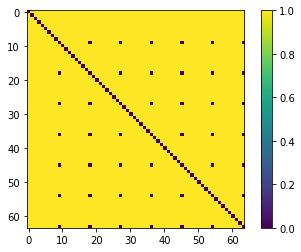

In [22]:
plt.imshow(realQ.real<0)
plt.colorbar()
plt.show()

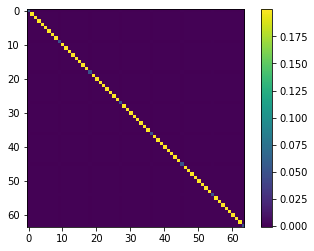

In [23]:
plt.imshow(realQ.real)
plt.colorbar()
plt.show()

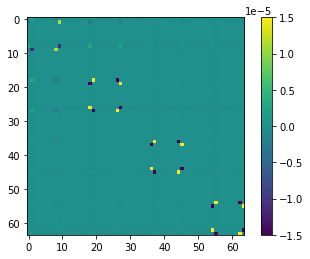

In [24]:
plt.imshow(realQ.imag)
plt.colorbar()
plt.show()

Only use the estimation in the final iteration as the valid output

In [25]:
# total_smoother_dens = []
# total_smoother_purs = []
# for i in range(1,max_num_itrs+1):
#     print("Circuit Iteration", i)
#     observs = total_simu_probs[0:i]
#     learn_obj = EMLearn(observs, unitaries[0], x, M, Q, R, P)
#     estX0, estM0, estQ, estR, estF = learn_obj.learn() # they are all arguemented
    
#     # Slice from argumented system
#     realX0 = estX0.toarray()[:num_dim_state]
#     realX0norm = np.sqrt(np.sum(np.abs(realX0)**2))
#     realM0 = estM0.toarray()[range(num_dim_state),:][:,range(num_dim_state)]
#     realF = estF.toarray()[range(num_dim_state),:][:,range(num_dim_state)]
#     realQ = estQ.toarray()[range(num_dim_state),:][:,range(num_dim_state)]
#     realR = estR.toarray()[range(num_dim_obs),:][:,range(num_dim_obs)]
#     realP = estQ.toarray()[range(num_dim_state),:][:,range(num_dim_state, 2*num_dim_state)]

#     smoother = KSQS(observs, realF, realX0, realM0, realQ, realR, realP)
#     x_seq, M_seq, M_prio_seq = smoother.smooth() 
    
    
#     # Normalization
# #     x_est_norms = []
# #     for j in range(i):
# #         x_est = np.array(x_seq[j+1][:num_dim_state].todense()).flatten()
# #         diag_sum = np.sum(vecden_meas(x_est))

# #         #normalize along the diagonal
# #         x_est_norm = x_est+0
# #         nrows = int(np.sqrt(x_est.size))
# #         for k in range(nrows):
# #             x_est_norm[k*nrows+k] = x_est_norm[k*nrows+k]/diag_sum
# #     final_den = x_est_norm.reshape(num_dim_obs, num_dim_obs)

#     x_est = np.matrix(x_seq[-1][:num_dim_state].todense()).flatten().reshape((num_dim_obs, num_dim_obs), order='F')
# #     x_est = (x_est+x_est.H)/2
#     final_den = KSEM.closed_den_mat(x_est)
#     total_smoother_dens.append(final_den)
#     total_smoother_purs.append(np.real(qi.DensityMatrix(final_den).purity()))

In [26]:
for den in total_smoother_dens:
    print("Is state a valid density matrix:", qi.DensityMatrix(den).is_valid())

Is state a valid density matrix: True
Is state a valid density matrix: True
Is state a valid density matrix: True
Is state a valid density matrix: True
Is state a valid density matrix: True
Is state a valid density matrix: True
Is state a valid density matrix: True
Is state a valid density matrix: True
Is state a valid density matrix: True
Is state a valid density matrix: True


In [27]:
total_smoother_dens[0].diagonal().flatten()

matrix([[9.51380444e-01+2.84278179e-27j, 1.21389097e-02-1.33297660e-25j,
         1.68393242e-02-3.12660549e-23j, 7.63669087e-03+5.16548748e-23j,
         7.94197258e-03+1.10215554e-23j, 2.24236112e-03-1.35551662e-23j,
         4.89493904e-04+0.00000000e+00j, 1.33080396e-03+0.00000000e+00j]])

In [28]:
np.diag(np.array(total_smoother_dens[0].diagonal()).flatten())

array([[9.51380444e-01+2.84278179e-27j, 0.00000000e+00+0.00000000e+00j,
        0.00000000e+00+0.00000000e+00j, 0.00000000e+00+0.00000000e+00j,
        0.00000000e+00+0.00000000e+00j, 0.00000000e+00+0.00000000e+00j,
        0.00000000e+00+0.00000000e+00j, 0.00000000e+00+0.00000000e+00j],
       [0.00000000e+00+0.00000000e+00j, 1.21389097e-02-1.33297660e-25j,
        0.00000000e+00+0.00000000e+00j, 0.00000000e+00+0.00000000e+00j,
        0.00000000e+00+0.00000000e+00j, 0.00000000e+00+0.00000000e+00j,
        0.00000000e+00+0.00000000e+00j, 0.00000000e+00+0.00000000e+00j],
       [0.00000000e+00+0.00000000e+00j, 0.00000000e+00+0.00000000e+00j,
        1.68393242e-02-3.12660549e-23j, 0.00000000e+00+0.00000000e+00j,
        0.00000000e+00+0.00000000e+00j, 0.00000000e+00+0.00000000e+00j,
        0.00000000e+00+0.00000000e+00j, 0.00000000e+00+0.00000000e+00j],
       [0.00000000e+00+0.00000000e+00j, 0.00000000e+00+0.00000000e+00j,
        0.00000000e+00+0.00000000e+00j, 7.63669087e-03+5.1654

In [29]:
with np.printoptions(precision=3, suppress=True):
    for den in total_smoother_dens:
        non_diag_den = den - np.diag(np.array(den.diagonal()).flatten())
        print(np.linalg.norm(non_diag_den))
#     print(total_smoother_dens[8])
#     print(total_simu_dens[8].data)

0.00942228585267435
0.08821925981091398
0.19363032140769262
0.3043385320704221
0.41692522359144774
0.5113401389784219
0.5691520152529342
0.6052285021259429
0.633683560440958
0.6528950847301443


In [30]:
print("Estimated Purity (Total)")
for pu in total_smoother_purs:
    print(pu)

Estimated Purity (Total)
0.9057728768758223
0.8497085391556927
0.7559580977439018
0.6973422362272663
0.6682397489170323
0.672342170909995
0.7062554852123459
0.7633575019617393
0.841676476341793
0.9102488470403216


## Check the fidelity between estimated state and the real state in the simulator

In [31]:
from scipy.linalg import sqrtm
def state_fid(m1,m2):
    sqm1 = sqrtm(m1)
    temp = sqm1.dot(m2).dot(sqm1)
    temp2 = sqrtm(temp)
    return np.real(np.trace(temp2))**2

Iteration 1 KS Fid: 0.9889405167596225 Tomo Fid: 0.9730143031673949
Iteration 2 KS Fid: 0.9348343418287524 Tomo Fid: 0.9701876958592491
Iteration 3 KS Fid: 0.8757744164885652 Tomo Fid: 0.972854360076102
Iteration 4 KS Fid: 0.8090448242462889 Tomo Fid: 0.9634640702949663
Iteration 5 KS Fid: 0.7430388839943474 Tomo Fid: 0.963082138983257
Iteration 6 KS Fid: 0.6549693112653729 Tomo Fid: 0.9606070201359896
Iteration 7 KS Fid: 0.5783841186042612 Tomo Fid: 0.9614935044002703
Iteration 8 KS Fid: 0.511375638522163 Tomo Fid: 0.9591524747332166
Iteration 9 KS Fid: 0.4597279559580963 Tomo Fid: 0.9675427852272717
Iteration 10 KS Fid: 0.42378140250225194 Tomo Fid: 0.9557415238797908


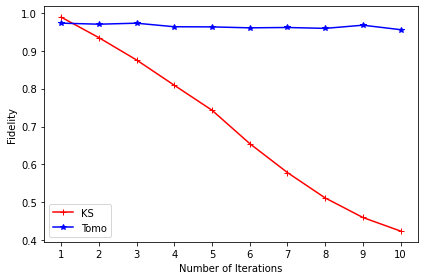

In [32]:
# Compare fidelity, use Qiskit API (when every state from KS is a valid density matrix)
diff_fed_all= []
diff_fed_tomo= []
for i in range(max_num_itrs):
    qis_den_tomo = qi.DensityMatrix(tomo_dens[i])
    qis_den_all = qi.DensityMatrix(total_smoother_dens[i])
    fed_difference_tomo =  qi.state_fidelity(total_simu_dens[i], qis_den_tomo)
    fed_difference_all =  qi.state_fidelity(total_simu_dens[i], qis_den_all)
    diff_fed_all.append(fed_difference_all)
    diff_fed_tomo.append(fed_difference_tomo)
    print("Iteration",i+1, "KS Fid:", fed_difference_all, "Tomo Fid:", fed_difference_tomo)
    
iter_range = range(max_num_itrs)
plt.plot(np.array(iter_range)+1, np.array(diff_fed_all)[iter_range], '+-', color='red', label='KS')
plt.plot(np.array(iter_range)+1, np.array(diff_fed_tomo)[iter_range], '*-', color='blue', label='Tomo')
# plt.plot(np.array(iter_range)+1, np.array([0.9]*max_num_itrs)[iter_range], '--', color='lightgray')
plt.xlabel("Number of Iterations")
plt.ylabel("Fidelity")
plt.xticks((np.array(iter_range)+1))
plt.legend()
plt.tight_layout()
# plt.savefig("diff_fed_qis.svg")
plt.show()

Iteration 1 KS Fid: 0.9889405167596218 Tomo Fid: 0.9730143029554319
Iteration 2 KS Fid: 0.9348343412412549 Tomo Fid: 0.9701876956725779
Iteration 3 KS Fid: 0.8757744155189604 Tomo Fid: 0.9728543599561439
Iteration 4 KS Fid: 0.8090448222179814 Tomo Fid: 0.9634640702678441
Iteration 5 KS Fid: 0.7430388841026965 Tomo Fid: 0.9630821392185348
Iteration 6 KS Fid: 0.6549693078181326 Tomo Fid: 0.9606070205452762
Iteration 7 KS Fid: 0.5783841173932218 Tomo Fid: 0.9614935043842553
Iteration 8 KS Fid: 0.5113756378793702 Tomo Fid: 0.9591524749322662
Iteration 9 KS Fid: 0.45972795756749796 Tomo Fid: 0.9675427851115264
Iteration 10 KS Fid: 0.4237813993303144 Tomo Fid: 0.9557415243705942


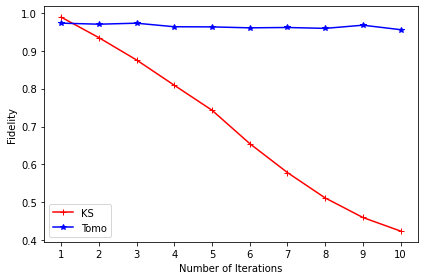

In [33]:
# Compare fidelity, use my own function (when some states from KS are not valid density matrices)
diff_fed_all= []
diff_fed_tomo= []
for i in range(max_num_itrs):
    fed_difference_tomo =  state_fid(total_simu_dens[i].data, tomo_dens[i])
    fed_difference_all =  state_fid(total_simu_dens[i].data, total_smoother_dens[i])
    diff_fed_all.append(fed_difference_all)
    diff_fed_tomo.append(fed_difference_tomo)
    print("Iteration",i+1, "KS Fid:", fed_difference_all, "Tomo Fid:", fed_difference_tomo)
    
iter_range = range(max_num_itrs)
plt.plot(np.array(iter_range)+1, np.array(diff_fed_all)[iter_range], '+-', color='red', label='KS')
plt.plot(np.array(iter_range)+1, np.array(diff_fed_tomo)[iter_range], '*-', color='blue', label='Tomo')
# plt.plot(np.array(iter_range)+1, np.array([0.9]*max_num_itrs)[iter_range], '--', color='lightgray')
plt.xlabel("Number of Iterations")
plt.ylabel("Fidelity")
plt.xticks((np.array(iter_range)+1))
plt.legend()
plt.tight_layout()
# plt.savefig("diff_fed.svg")
plt.show()

Iteration 1 KS Norm: 0.036632106538785084 Tomo Norm: 0.06041846269361675
Iteration 2 KS Norm: 0.11616825602932083 Tomo Norm: 0.07124160641415343
Iteration 3 KS Norm: 0.24391263160324198 Tomo Norm: 0.054597312249824656
Iteration 4 KS Norm: 0.37520443990773483 Tomo Norm: 0.07087460039997372
Iteration 5 KS Norm: 0.48776946731166615 Tomo Norm: 0.07140815762719419
Iteration 6 KS Norm: 0.6266699061314854 Tomo Norm: 0.07383222422861548
Iteration 7 KS Norm: 0.7356092728687155 Tomo Norm: 0.07561455614378652
Iteration 8 KS Norm: 0.8219797534288379 Tomo Norm: 0.07546631740851029
Iteration 9 KS Norm: 0.8954368440928527 Tomo Norm: 0.08193755578953157
Iteration 10 KS Norm: 0.9410738981142418 Tomo Norm: 0.08135930907294973


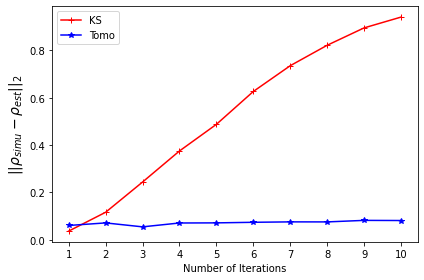

In [34]:
diff_norm_all= []
diff_norm_tomo= []
for i in range(max_num_itrs):
    norm_difference_tomo =  np.linalg.norm(total_simu_dens[i].data-tomo_dens[i])
    norm_difference_all =  np.linalg.norm(total_simu_dens[i].data-total_smoother_dens[i])
    diff_norm_all.append(norm_difference_all)
    diff_norm_tomo.append(norm_difference_tomo)
    print("Iteration",i+1, "KS Norm:", norm_difference_all, "Tomo Norm:", norm_difference_tomo)
    
iter_range = range(max_num_itrs)
plt.plot(np.array(iter_range)+1, np.array(diff_norm_all)[iter_range], '+-', color='red', label='KS')
plt.plot(np.array(iter_range)+1, np.array(diff_norm_tomo)[iter_range], '*-', color='blue', label='Tomo')
plt.xlabel("Number of Iterations")
plt.ylabel(r'$||\rho_{simu} - \rho_{est}||_2$', fontsize=14)
plt.xticks((np.array(iter_range)+1))
plt.legend()
plt.tight_layout()
# plt.savefig("diff_norm.svg")
plt.show()

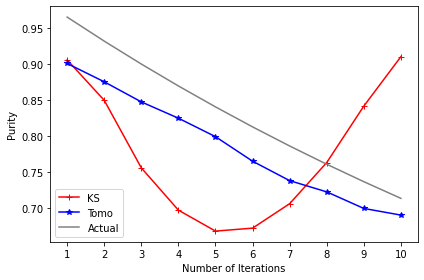

In [35]:
plt.plot(np.array(iter_range)+1, np.array(total_smoother_purs)[iter_range], '+-', label="KS",color='red')
plt.plot(np.array(iter_range)+1, np.array(tomo_purs)[iter_range], '*-', label="Tomo",color='blue')
# plt.plot(np.array(iter_range)+1, np.array(total_smoother_purs)[iter_range]-0.25, '+-', label="Estimated-0.25",color='skyblue')
plt.plot(np.array(iter_range)+1, np.array(total_simu_purs)[iter_range], label="Actual", color='gray')
plt.xlabel("Number of Iterations")
plt.ylabel("Purity")
plt.xticks((np.array(iter_range)+1))
plt.legend()
plt.tight_layout()
# plt.savefig("diff_pur.svg")
plt.show()

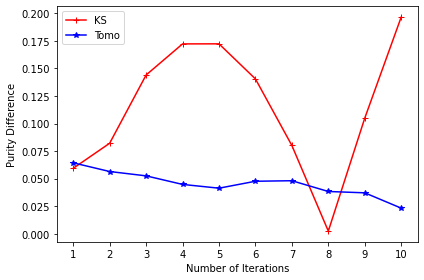

In [36]:
plt.plot(np.array(iter_range)+1, np.abs(np.array(total_simu_purs)-np.array(total_smoother_purs))[iter_range], '+-', label="KS",color='red')
plt.plot(np.array(iter_range)+1, np.abs(np.array(total_simu_purs)-np.array(tomo_purs))[iter_range], '*-', label="Tomo",color='blue')

plt.xlabel("Number of Iterations")
plt.ylabel("Purity Difference")
plt.xticks((np.array(iter_range)+1))
plt.legend()
plt.tight_layout()
# plt.savefig("diff_pur_diff.svg")
plt.show()